## Getting the Data
We will be using cupy and cudf libraries from RAPIDS for those tasks

In [1]:
import cupy as np
import cudf as pd 
path=''
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        path=os.path.join(dirname, filename)
    
df=pd.read_csv(path)

Checking the head of the dataframe that we have loaded just now.

In [2]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1971-02-05,100.000000,100.000000,100.000000,100.000000,100.000000,0
1,1971-02-08,100.839996,100.839996,100.839996,100.839996,100.839996,0
2,1971-02-09,100.760002,100.760002,100.760002,100.760002,100.760002,0
3,1971-02-10,100.690002,100.690002,100.690002,100.690002,100.690002,0
4,1971-02-11,101.449997,101.449997,101.449997,101.449997,101.449997,0


## Checking Null Values

firstly we will print the structure of the dataset. We check for null values in the data frame to ensure that there are none. The existence of null values in the dataset causes issues during training since they function as outliers, creating a wide variance in the training process.

In [3]:
df.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 12824 entries, 0 to 12823
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Date       12824 non-null  object
 1   Open       12824 non-null  float64
 2   High       12824 non-null  float64
 3   Low        12824 non-null  float64
 4   Close      12824 non-null  float64
 5   Adj Close  12824 non-null  float64
 6   Volume     12824 non-null  int64
dtypes: float64(5), int64(1), object(1)
memory usage: 776.5+ KB


In [4]:
#which columns contains how many null values
null_columns=[]
for col in df.columns:
    null_columns.append(df[col].isnull().sum())
print(null_columns)
target='Adj Close'

[0, 0, 0, 0, 0, 0, 0]


If we run the above piece of code, we can see that no null values found from the above 

## Preprocessing

We will drop the date column for now and append it later on beacuse this way it will be easy for us to convert the whole dataframe into a 2-D array which we will split into train and test samples and apply the machine learning models later on.

In [5]:
df1=df.drop(columns=['Date'],axis='columns')
df1.head()

,Open,High,Low,Close,Adj Close,Volume
0,100.000000,100.000000,100.000000,100.000000,100.000000,0
1,100.839996,100.839996,100.839996,100.839996,100.839996,0
2,100.760002,100.760002,100.760002,100.760002,100.760002,0
3,100.690002,100.690002,100.690002,100.690002,100.690002,0
4,101.449997,101.449997,101.449997,101.449997,101.449997,0


We have dropped the date column. So we are left with only the numerical features. We can now safely apply .values() and .tolist() function on the cudf.DataFrame object. After converting all the neumeric features into 2D array we append the dates.

In [6]:
rows=df1.values.tolist()
rows.reverse()
# rows[:3]
date_index=0;
for row in rows:
    row.reverse()
    row.append(df['Date'][date_index])
    row.reverse()
    date_index+=1

rows[:3]

[['1971-02-05',
  15690.650391,
  15792.639648000002,
  15618.879882999998,
  15786.990233999999,
  15786.990233999999,
  4600800000.0],
 ['1971-02-08',
  15510.910156,
  15720.089844,
  15507.660156,
  15686.919922,
  15686.919922,
  5091220000.0],
 ['1971-02-09',
  15117.629883,
  15281.990233999999,
  14931.610352000002,
  15225.150391,
  15225.150391,
  5095960000.0]]

## Train Test Split

We first apply models on only the dates and the target_column. So we have extracted the date column and the target_column from the 2D array that we have created just now.

In [7]:
X,Y=[],[]
for row in rows:
    X.append(int(''.join(row[0].split('-'))))
    Y.append(row[5])

Split X, Y into x_train, x_test, y_train, y_test

In [8]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X,Y,train_size=0.9,test_size=0.1)
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

x_train = x_train.reshape(-1,1)
x_test = x_test.reshape(-1,1)

In [9]:
print(x_train.shape,x_test.shape)

(11541, 1) (1283, 1)


## Applying Model

A linear regression model, random forest regressor and a gradient boosting regressor are chosen to be compared. The training data is given to all four of the models and then we pass the testing data and obtain the predicted values for each model which we use to plot and visualise.



## Linear Regression model

In [10]:
from cuml import LinearRegression
from cuml.linear_model import LinearRegression

algorithms=['svd','eig','qr','svd-qr','svd-jacobi']
for algo in algorithms:
    print('***',algo,'***')
    lr = LinearRegression(fit_intercept = True, normalize = False,
                      algorithm = algo)
    reg = lr.fit(x_train.astype('float32'),y_train)
    print("Coefficients:")
    print(reg.coef_)
    print("Intercept:")
    print(reg.intercept_)

    preds = lr.predict(x_test)

    print(preds)

*** svd ***
Coefficients:
[-0.01495823]
Intercept:
300695.9375
[4518.4062  -121.625   5701.3438  ... 1828.6562   328.71875 1065.7812 ]
*** eig ***
Coefficients:
[-0.01495823]
Intercept:
300695.9375
[4518.4062  -121.625   5701.3438  ... 1828.6562   328.71875 1065.7812 ]
*** qr ***
Coefficients:
[-0.01495823]
Intercept:
300695.9375
[4518.4062  -121.625   5701.3438  ... 1828.6562   328.71875 1065.7812 ]
*** svd-qr ***
Coefficients:
[-0.01495823]
Intercept:
300695.9375
[4518.4062  -121.625   5701.3438  ... 1828.6562   328.71875 1065.7812 ]
*** svd-jacobi ***
Coefficients:
[-0.01495823]
Intercept:
300695.9375
[4518.4062  -121.625   5701.3438  ... 1828.6562   328.71875 1065.7812 ]


/opt/conda/lib/python3.7/site-packages/cuml/internals/api_decorators.py:409: UserWarning: Changing solver from 'eig' to 'svd' as eig solver does not support training data with 1 column currently.
  return func(*args, **kwargs)


In [11]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X,Y,train_size=0.9,test_size=0.1)
x_train = np.asnumpy(x_train)
y_train = np.asnumpy(y_train)
x_test = np.asnumpy(x_test)
y_test = np.asnumpy(y_test)
x_train = x_train.reshape(-1,1)
x_test = x_test.reshape(-1,1)

## Random Forest Classifier

In [12]:
from sklearn.ensemble import RandomForestRegressor
clf_rf = RandomForestRegressor(n_estimators=100)
clf_rf.fit(x_train,y_train)
y_pred_rf = clf_rf.predict(x_test)

print("Accuracy of Random Forest Model:",clf_rf.score(x_test,y_test))

Accuracy of Random Forest Model: 0.9997531168730148


## Gradient Boosting Regressor

In [13]:
from sklearn.ensemble import GradientBoostingRegressor
clf_gb = GradientBoostingRegressor(n_estimators=200)
clf_gb.fit(x_train,y_train)
y_pred_gb = clf_gb.predict(x_test)

print("Accuracy of Gradient Boosting Model:",clf_gb.score(x_test,y_test))

Accuracy of Gradient Boosting Model: 0.9993157574581855


We can observe that linear regression has been the worst performing model of all, it failed to predict the correct values a considerable number of times compared to other algorithms.

The random forest regressor is the best model to use out of all three. Random forest regressor is the model to go for.Gradient Boosting comes a close second. 

Using the subplot feature, we plot the multiple predicted values from different models to visualise how good our algorithms can predict the values.

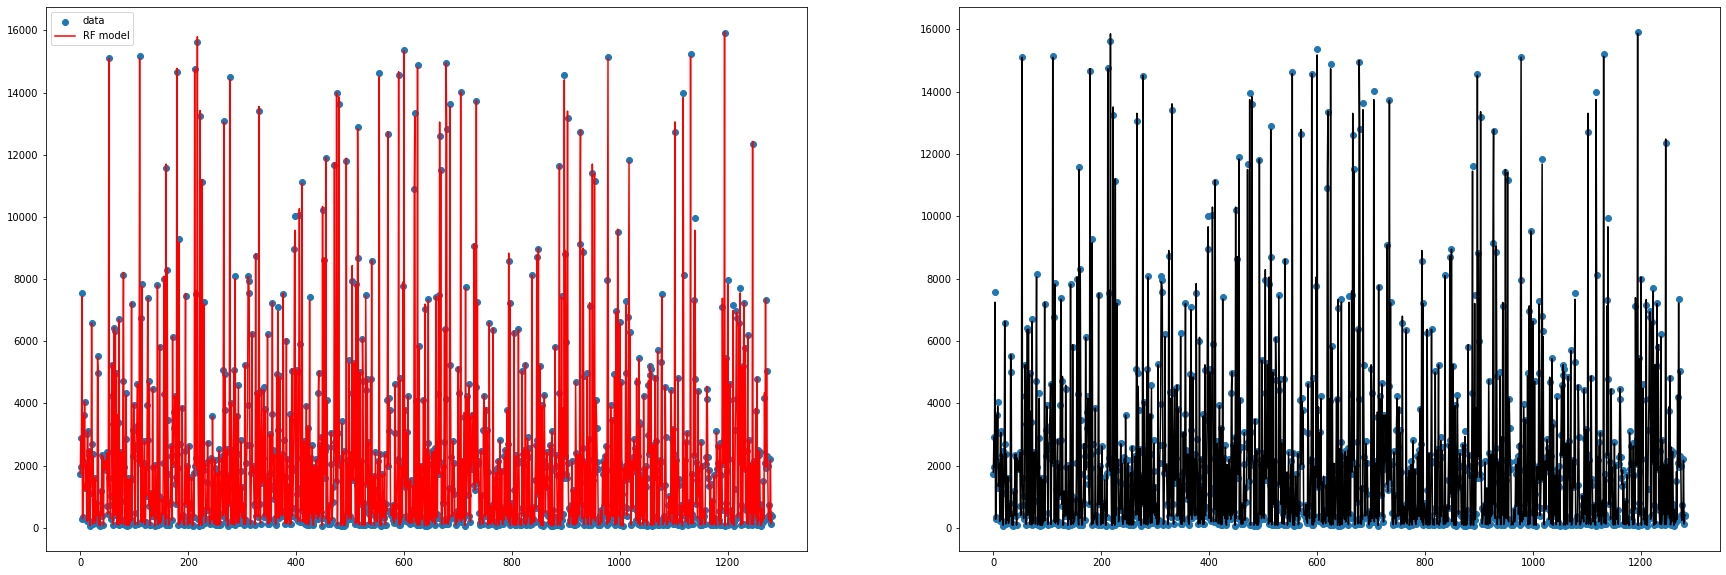

In [14]:
import matplotlib.pyplot as plt 
f1,(ax3,ax4) = plt.subplots(1,2,figsize=(30,10))

# Random Forest Regressor
ax3.scatter(range(len(y_test)),y_test,label='data')
ax3.plot(range(len(y_test)),y_pred_rf,color='red',label='RF model')
ax3.legend()

# Gradient Boosting Regressor
ax4.scatter(range(len(y_test)),y_test,label='data')
ax4.plot(range(len(y_test)),y_pred_gb,color='black',label='GB model')


## LSTM (long short term memory)

We will use the Long Short-Term Memory(LSTM) method to create a Machine Learning model to forecast the stock values. Long-term memory (LSTM) is a deep learning artificial recurrent neural network (RNN) architecture.

Unlike traditional feed-forward neural networks, LSTM has feedback connections. It can handle single data points (such as pictures) as well as full data sequences (such as speech or video).

In [15]:
import numpy as np
import pandas as pd 
path=''
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        path=os.path.join(dirname, filename)
    
df=pd.read_csv(path)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12824 entries, 0 to 12823
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       12824 non-null  object 
 1   Open       12824 non-null  float64
 2   High       12824 non-null  float64
 3   Low        12824 non-null  float64
 4   Close      12824 non-null  float64
 5   Adj Close  12824 non-null  float64
 6   Volume     12824 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 701.4+ KB


In [17]:
null_cols=[]
for col in df.columns:
    null_cols.append(df[col].isnull().sum())
print(null_cols)

[0, 0, 0, 0, 0, 0, 0]


## Plotting the True Adjusted Close Value

The Adjusted Close Value is the final output value that will be forecasted using the Machine Learning model. This figure indicates the stock’s closing price on that particular day of stock market trading.

<AxesSubplot:>

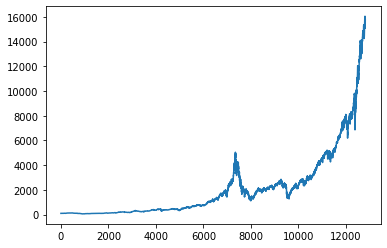

In [18]:
%matplotlib inline
import matplotlib. pyplot as plt
import matplotlib
target_col='Adj Close'
df[target_col].plot()

## Feature Selection

The output column is then assigned to the target variable in the following step. It is the adjusted relative value of the Microsoft Stock in this situation. Furthermore, we pick the features that serve as the independent variable to the target variable (dependent variable). We choose four characteristics to account for training purposes:Open, High, Low, Volume

In [19]:
output_var=pd.DataFrame(df[target_col])
features = ['Open','High','Low','Volume']

## Scaling

To decrease the computational cost of the data in the table, we will scale the stock values to values between 0 and 1. As a result, all of the data in large numbers is reduced, and therefore memory consumption is decreased. Also, because the data is not spread out in huge values, we can achieve greater precision by scaling down. To perform this we will be using the MinMaxScaler class of the sci-kit-learn library.

In [20]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(df[features])
feature_transform= pd.DataFrame(columns=features, data=feature_transform, index=df.index)
feature_transform.head()

,Open,High,Low,Volume
0,0.002809,0.002793,0.002827,0.0
1,0.002861,0.002845,0.002880,0.0
2,0.002856,0.002840,0.002875,0.0
3,0.002852,0.002836,0.002871,0.0
4,0.002899,0.002883,0.002918,0.0


## Train Test Split

We have to divide the entire dataset into training and test sets before feeding it into the training model. The Machine Learning LSTM model will be trained on the data in the training set and tested for accuracy and backpropagation on the test set.

The sci-kit-learn library’s TimeSeriesSplit class will be used for this. We set the number of splits to 10, indicating that 10% of the data will be used as the test set and 90% of the data would be used to train the LSTM model. The advantage of utilising this Time Series split is that the split time series data samples are examined at regular time intervals.

In [21]:
from sklearn.model_selection import TimeSeriesSplit
timesplit= TimeSeriesSplit(n_splits=10)
for train_index, test_index in timesplit.split(feature_transform):
    X_train, X_test=feature_transform[:len(train_index)], feature_transform[len(train_index): (len(train_index)+len(test_index))]
    y_train, y_test=output_var[:len(train_index)].values.ravel(), output_var[len(train_index): (len(train_index)+len(test_index))].values.ravel()

Once the training and test sets are finalized, we will input the data into the LSTM model. Before we can do that, we must transform the training and test set data into a format that the LSTM model can interpret. As the LSTM needs that the data to be provided in the 3D form, we first transform the training and test data to NumPy arrays and then restructure them to match into the format (Number of Samples, 1, Number of Features).

In [22]:
trainX =np.array(X_train)
testX =np.array(X_test)
X_train = trainX.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])

## Applying the LSTM model

We will now build a Sequential Keras model with one LSTM layer. The LSTM layer has 32 units and is followed by one Dense Layer of one neuron.

We compile the model using Adam Optimizer and the Mean Squared Error as the loss function. For an LSTM model, this is the most preferred combination. The model is plotted and presented below.

2022-03-16 16:05:59.786447: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-16 16:05:59.791418: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-16 16:05:59.792107: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-16 16:05:59.793134: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

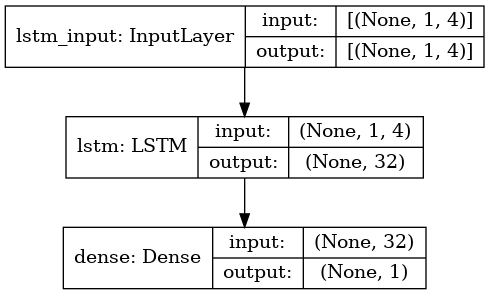

In [23]:
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import TimeSeriesSplit
from sklearn import linear_model
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras.layers import LSTM
from keras.utils.vis_utils import plot_model
lstm = Sequential()
lstm.add(LSTM(32, input_shape=(1, trainX.shape[1]), activation='relu',return_sequences=False))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error', optimizer='adam')
plot_model(lstm, show_shapes=True, show_layer_names=True)

We use the fit function to train the LSTM model created above on the training data for 100 epochs with a batch size of 8.

In [24]:
history=lstm.fit(X_train, y_train, epochs=100, batch_size=8, verbose=1, shuffle=False)

2022-03-16 16:06:02.959025: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
1458/1458 [==============================] - 8s 5ms/step - loss: 3698077.5000
Epoch 2/100
1458/1458 [==============================] - 7s 5ms/step - loss: 3326866.5000
Epoch 3/100
1458/1458 [==============================] - 8s 5ms/step - loss: 2906717.7500
Epoch 4/100
1458/1458 [==============================] - 7s 5ms/step - loss: 2480994.0000
Epoch 5/100
1458/1458 [==============================] - 7s 5ms/step - loss: 2086782.3750
Epoch 6/100
1458/1458 [==============================] - 7s 5ms/step - loss: 1746946.2500
Epoch 7/100
1458/1458 [==============================] - 7s 5ms/step - loss: 1459236.3750
Epoch 8/100
1458/1458 [==============================] - 7s 5ms/step - loss: 1180937.3750
Epoch 9/100
1458/1458 [==============================] - 8s 5ms/step - loss: 882065.0000
Epoch 10/100
1458/1458 [==============================] - 7s 5ms/step - loss: 620710.9375
Epoch 11/100
1458/1458 [==============================] - 7s 5ms/step - loss: 435633.9688
Epoch 12/10

Finally, we can observe that the loss value has dropped exponentially over time over the 100-epoch training procedure, reaching a value of 396.0334.

We have our model ready now, we can use it to forecast the Adjacent Close Value of the Microsoft stock by using a model trained using the LSTM network on the test set. This is accomplished by employing the simple predict function on the LSTM model that has been created.

We will also display the graph to compare both Adj Close’s true values and Adj Close’s predicted value using the LSTM Machine Learning model.

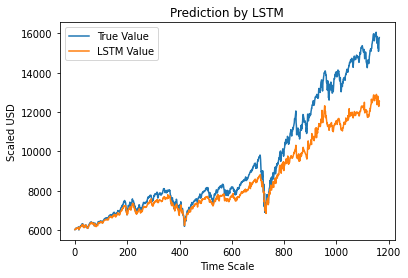

In [25]:
y_pred= lstm.predict(X_test)


plt.plot(y_test, label='True Value')
plt.plot(y_pred, label='LSTM Value')
plt.title('Prediction by LSTM')
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.show()